## Import Libraries

We imported all of the libraries needed for the project below!

In [1]:
# Import necessary libraries
import torch
import pyro
import numpy as np
import pandas as pd
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.infer.autoguide import AutoNormal
import matplotlib.pyplot as plt

/opt/anaconda3/envs/cs179/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Data

We just read in the CSV file that was created earlier (``ca_restaurants_bayesian_dataset.csv``):
business_id,name,avg_rating,avg_sentiment_score,log_review_count

After loading the data into a Pandas DataFrame, we extract the columns named `avg_sentiment_score`, `log_review_count`, and `avg_rating` (these were really the only parts of the csv file we needed for our model). We then convert these columns into tensors so that they can be fed directly into our Pyro model. The tensor `X_sentiment` holds each restaurant’s sentiment score, `X_log_reviews` holds the log review counts, and `y` holds the target ratings we want to predict.


In [2]:
# Load the dataset
df = pd.read_csv("ca_restaurants_bayesian_dataset.csv")

# Extract the features and target
X_sentiment = torch.tensor(df["avg_sentiment_score"].values, dtype=torch.float)
X_log_reviews = torch.tensor(df["log_review_count"].values, dtype=torch.float)
y = torch.tensor(df["avg_rating"].values, dtype=torch.float)

## Split Data into Training and Test Sets

We will randomly split it so that 80% of the examples are used for training and 20% for test. This ensures that our model is evaluated on data it has not seen during training.

In [3]:
# Split into training and test sets (80% train, 20% test)
n = X_sentiment.shape[0]
indices = torch.randperm(n)
train_size = int(0.8 * n)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train_sentiment = X_sentiment[train_idx]
X_train_log_reviews = X_log_reviews[train_idx]
y_train = y[train_idx]

X_test_sentiment = X_sentiment[test_idx]
X_test_log_reviews = X_log_reviews[test_idx]
y_test = y[test_idx]

print(f"Training set size: {train_size}")
print(f"Test set size: {n - train_size}")

Training set size: 547
Test set size: 137


## Model

The Bayesian linear regression model assumes that each restaurant’s rating just comes from a normal distribution whose mean depends on two inputs (the average review sentiment and the log review count).

We first assign prior distributions to each parameter:

- `alpha` is the intercept, drawn from a Normal(0, 1) prior.
- `beta_sentiment` is the slope for sentiment score, drawn from Normal(0, 1).
- `beta_reviews` is the slope for log review count, drawn from Normal(0, 1).
- `sigma` is the standard deviation of the noise, drawn from a HalfNormal(1) prior.

We then do `mean` = `alpha` + `beta_sentiment * X_sentiment` + `beta_reviews * X_log_reviews`. Each observed rating `y` is sampled from a Normal distribution centered at `mean` with standard deviation `sigma`. Pyro will just use this to compare model predictions against the actual ratings during inference.

In [4]:
# Define the Bayesian model
def bayesian_model(X_sentiment, X_log_reviews, y=None):
    # Define priors for the model parameters
    alpha = pyro.sample("alpha", dist.Normal(0.0, 1.0))
    beta_sentiment = pyro.sample("beta_sentiment", dist.Normal(0.0, 1.0))
    beta_log_reviews = pyro.sample("beta_reviews", dist.Normal(0.0, 1.0))
    sigma = pyro.sample("sigma", dist.HalfNormal(1.0))

    # Define the linear model
    mean = alpha + beta_sentiment * X_sentiment + beta_log_reviews * X_log_reviews
    
    # Sample from the likelihood
    with pyro.plate("data", len(X_sentiment)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

## Guide

This just automatically creates a normal distribution for each model parameter, allowing SVI to learn an approximate posterior without manually defining each variational distribution.

In [5]:
# Define the guide for mean-field variational inference
guide = AutoNormal(bayesian_model)

Fit the model with stochastic variational inference. Train the model with 5000 steps and print the loss.
## Train the Model with Variational Inference

Training process yay:

We set up an optimizer with a learning rate of 0.01 and tell Pyro to use the evidence lower bound as the loss function for variational inference. We then run a loop for 5000 steps. On each step Pyro updates the guide’s parameters to minimize the bound. Every 500 steps we also go ahead and print out the current loss so that we can track how training progresses toward convergence.


In [6]:
# Clear the parameter store
pyro.clear_param_store()

# Define the Stochastic Variational Inference (SVI) object
svi = SVI(
    model=bayesian_model,
    guide=guide,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()
)

# Train for 5000 steps using the training data
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(X_train_sentiment, X_train_log_reviews, y_train)
    
    # Print the loss every 500 steps
    if step % 500 == 0:
        print(f"Step {step}: loss = {loss}")


Step 0: loss = 3832.5961600244045
Step 500: loss = 535.243525326252
Step 1000: loss = 126.03536343574524
Step 1500: loss = 71.17474853992462
Step 2000: loss = 69.17957139015198
Step 2500: loss = 68.80461239814758
Step 3000: loss = 69.14493626356125
Step 3500: loss = 68.63025861978531
Step 4000: loss = 68.10737305879593
Step 4500: loss = 85.41186553239822


## Posterior Samples

We examine the fitted model by drawing samples from the approx posterior distribution of each parameter.

Then once we have the samples, we just compute the mean and a 95 percent credible interval for each parameter by taking the 2.5th and 97.5th percentiles. Printing these values shows our best estimates for how sentiment and review count influence the predicted rating, along with how uncertain those estimates are.


In [7]:
# Extract the learned parameters
predictive_train = Predictive(
    bayesian_model,
    guide=guide,
    num_samples=1000,
    return_sites=["alpha", "beta_sentiment", "beta_reviews", "sigma"]
)

# Generate samples from the posterior predictive distribution
samples_train = predictive_train(X_train_sentiment, X_train_log_reviews)

for parameter in ["alpha", "beta_sentiment", "beta_reviews", "sigma"]:
    vals = samples_train[parameter].detach().numpy()
    mean_val = vals.mean()
    ci_lower, ci_upper = np.percentile(vals, [2.5, 97.5])
    print(f"{parameter}: mean = {mean_val:.3f}, 95% CI = ({ci_lower:.3f}, {ci_upper:.3f})")

alpha: mean = 1.878, 95% CI = (1.855, 1.902)
beta_sentiment: mean = 3.055, 95% CI = (3.024, 3.085)
beta_reviews: mean = -0.015, 95% CI = (-0.019, -0.010)
sigma: mean = 0.264, 95% CI = (0.246, 0.280)


work in progress

In [8]:
# Draw posterior predictive samples for the test inputs
predictive_test = Predictive(
    bayesian_model,
    guide=guide,
    num_samples=1000,
    return_sites=["obs"]
)

samples_test = predictive_test(X_test_sentiment, X_test_log_reviews)
# samples_test["obs"] has shape [1000, test_size]
y_pred_mean = samples_test["obs"].mean(dim=0)  # average over the 1000 samples

# Compute RMSE on test set
rmse = torch.sqrt(((y_pred_mean - y_test) ** 2).mean())
print(f"Test RMSE: {rmse:.3f}")

Test RMSE: 0.268


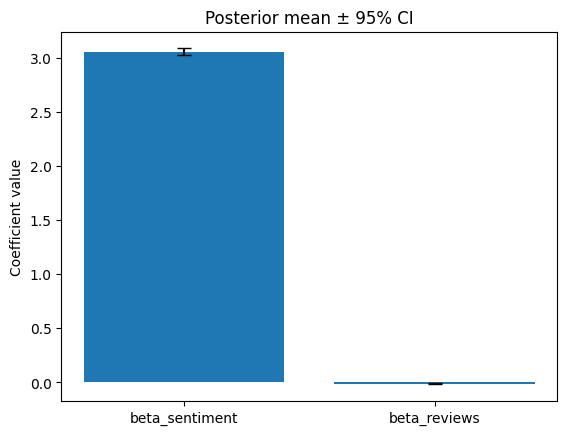

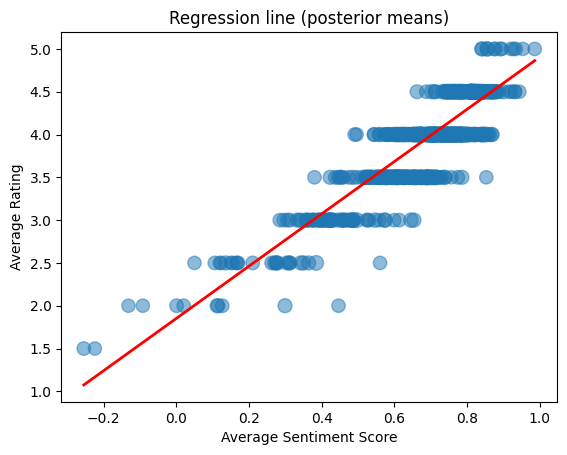

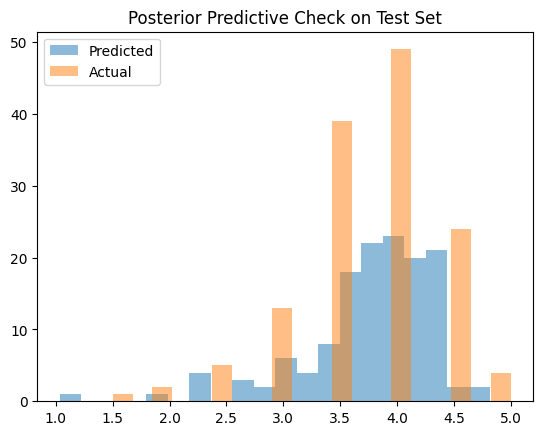

In [9]:
# 1. Plot ELBO loss curve (if you logged it during training)
#    You would need to record loss values into a list in Cell E, e.g.:
#    losses.append(loss) and then here do plt.plot(losses).

# 2. Bar chart of beta_sentiment and beta_reviews with 95% intervals
beta_samps = samples_train["beta_sentiment"].detach().numpy()
beta_r_samps = samples_train["beta_reviews"].detach().numpy()
plt.figure()
plt.bar(
    ["beta_sentiment", "beta_reviews"],
    [beta_samps.mean(), beta_r_samps.mean()],
    yerr=[
        [beta_samps.mean() - np.percentile(beta_samps, 2.5),
         beta_r_samps.mean() - np.percentile(beta_r_samps, 2.5)],
        [np.percentile(beta_samps, 97.5) - beta_samps.mean(),
         np.percentile(beta_r_samps, 97.5) - beta_r_samps.mean()]
    ],
    capsize=5
)
plt.ylabel("Coefficient value")
plt.title("Posterior mean ± 95% CI")
plt.show()

# 3. Scatter of sentiment vs. rating, sized by log review count, plus regression line
sent = df["avg_sentiment_score"].values
logrev = df["log_review_count"].values
rating = df["avg_rating"].values

# Use posterior means for regression line
alpha_mean = samples_train["alpha"].mean().item()
beta_s_mean = beta_samps.mean()
beta_r_mean = beta_r_samps.mean()

# Create a grid of sentiment values
sent_grid = np.linspace(sent.min(), sent.max(), 100)
logrev_mean = logrev.mean()
pred_line = alpha_mean + beta_s_mean * sent_grid + beta_r_mean * np.log(1 + logrev_mean)

plt.figure()
plt.scatter(sent, rating, s=10 + 50*np.log1p(logrev), alpha=0.5)
plt.plot(sent_grid, pred_line, color="red", linewidth=2)
plt.xlabel("Average Sentiment Score")
plt.ylabel("Average Rating")
plt.title("Regression line (posterior means)")
plt.show()

# 4. Posterior predictive check (histogram of y_pred vs. y_test)
plt.figure()
plt.hist(y_pred_mean.detach().numpy(), bins=20, alpha=0.5, label="Predicted")
plt.hist(y_test.detach().numpy(), bins=20, alpha=0.5, label="Actual")
plt.legend()
plt.title("Posterior Predictive Check on Test Set")
plt.show()
